In [179]:
import pandas as pd 
import numpy as np
import seaborn as sns
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [180]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ramvegiraju/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [181]:
train = pd.read_csv('/Users/ramvegiraju/Desktop/personalProjects/ContestsKaggle/SentAnalysisMovieReviews/Data/train.tsv', sep="\t")
test = pd.read_csv('/Users/ramvegiraju/Desktop/personalProjects/ContestsKaggle/SentAnalysisMovieReviews/Data/test.tsv', sep="\t")

In [182]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [183]:
#Check for missing records
train.isnull().sum(axis=0)

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [184]:
test.isnull().sum(axis=0)

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

In [185]:
#How many values for each sentiment
train['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [187]:
#Need to make categorical for sentiment
train['Sentiment'] = train['Sentiment'].astype('str')

In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


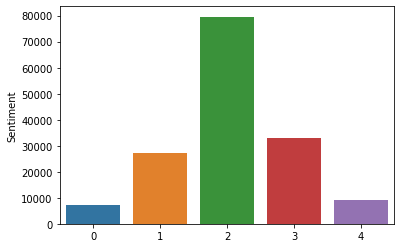

In [189]:
#Visualize how many reviews per Sentiment to see if the dataset is balanced
sns.barplot(x=train.Sentiment.value_counts().index,y=train.Sentiment.value_counts())

In [190]:
#Average word length of phrases
print(np.mean(train['Phrase'].apply(lambda x: len(x.split()))))
print(np.mean(test['Phrase'].apply(lambda x: len(x.split()))))
#Approximately an average of 7 words per phrase, removing stop words would not be effective in this scenario due to lack of words for each phrase, may take away from sentiment

7.203364090734333
6.6785886683159355


In [191]:
#The average seems to be tilted by the abundance of Sentiment values with 2, due to the imbalance in data
lowestSent = train[train['Sentiment'] == '0']
print(np.mean(lowestSent['Phrase'].apply(lambda x: len(x.split()))))
oneSent = train[train['Sentiment'] == '1']
print(np.mean(oneSent['Phrase'].apply(lambda x: len(x.split()))))
twoSent = train[train['Sentiment'] == '2']
print(np.mean(twoSent['Phrase'].apply(lambda x: len(x.split()))))
threeSent = train[train['Sentiment'] == '3']
print(np.mean(threeSent['Phrase'].apply(lambda x: len(x.split()))))
fourSent = train[train['Sentiment'] == '4']
print(np.mean(fourSent['Phrase'].apply(lambda x: len(x.split()))))

12.105345022624434
9.112015546511202
5.194616873162273
8.446593980623804
10.701390397566804


In [192]:
#Preprocess and clean the text prior to dealing with imbalancing
def clean_review(phraseCol):
    """Lemmatize, clean data"""
    review_corpus=[]
    for i in range(0,len(phraseCol)):
        review=str(phraseCol[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())] 
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus
train['clean_review'] = clean_review(train.Phrase.values)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [228]:
#Model 1: Vader Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
train['Sentiment'] = train['clean_review'].apply(lambda clean_review:sid.polarity_scores(clean_review))

In [229]:
train['compound'] = train['SentimentScore'].apply(lambda d:d['compound'])
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,compound,SentimentScore
0,1,1,A series of escapades demonstrating the adage ...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",a series of escapade demonstrating the adage t...,0.5579,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp..."
1,2,1,A series of escapades demonstrating the adage ...,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",a series of escapade demonstrating the adage t...,0.4404,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp..."
2,3,1,A series,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",a series,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,4,1,A,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",a,0.0000,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
4,5,1,series,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",series,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [224]:
def returnSent(compound):
    if compound == 0:
        return 0
    if compound > 0 and compound <= .25:
        return 1
    if compound > .25 and compound <= .50:
        return 2
    if compound > .50 and compound <= .75:
        return 3
    if compound > .75:
        return 4

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(train['Sentiment', 'compound'])

In [193]:
#Finding unique words
from nltk import word_tokenize
from nltk import FreqDist
all_words=' '.join(train['Phrase'])
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

18218

In [194]:
#Max Length of a review
r_len=[]
for text in train['Phrase']:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

53

In [195]:
#Undersampling to deal with the imbalanced dataset, now we have an equal amount of values for each class
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
X = train['clean_review']
y = train['Sentiment']
tvec = TfidfVectorizer(stop_words=None, max_features=100000)
X = tvec.fit_transform(X)
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)
print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({'2': 79582, '3': 32927, '1': 27273, '4': 9206, '0': 7072})
Resample dataset shape Counter({'0': 7072, '1': 7072, '2': 7072, '3': 7072, '4': 7072})


In [201]:
train_text = train.clean_review.values
target = train.Sentiment.values
y = to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


In [202]:
from sklearn.model_selection import train_test_split
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


In [203]:
#Unique words for train
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13732

In [204]:
#Max length for train
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [209]:
#Model2: LSTM
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=5

#Tokenize text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)

#Padding sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
print(X_train.shape,X_val.shape)

(124848, 48) (31212, 48)


In [210]:
#LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
model2=Sequential()
model2.add(Embedding(max_features,100,mask_zero=True))
model2.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
#model1.add(Dropout(.5))
model2.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
#model1.add(Dropout(.5))
model2.add(Dense(num_classes,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1373200   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 1,428,021
Trainable params: 1,428,021
Non-trainable params: 0
_________________________________________________________________


In [211]:
#With more epochs can increase accuracy
history1=model2.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/3
976/976 [==============================] - 156s 159ms/step - loss: 1.0355 - accuracy: 0.5948 - val_loss: 0.8640 - val_accuracy: 0.6485
Epoch 2/3
976/976 [==============================] - 155s 159ms/step - loss: 0.8192 - accuracy: 0.6642 - val_loss: 0.8301 - val_accuracy: 0.6592
Epoch 3/3
976/976 [==============================] - 148s 152ms/step - loss: 0.7643 - accuracy: 0.6839 - val_loss: 0.8193 - val_accuracy: 0.6666
